# LSTM for Predictive Maintenance on Pump Sensor Data
we are looking into predictive maintenance for pump sensor data. Our approach is quite generic towards time-series analysis, even though each step might look slightly different in your own project. The idea is to give you an idea about the general thought process and how you would attack such a problem. For a complete overview of the steps, please see the figure at the end of the article (maybe open it in parallel while reading). It should help to organize all steps in a logical order.

Anomaly detection is not a new concept or technique, it has been around for a number of years and is a common application of Machine Learning. The real world examples of its use cases include (but not limited to) detecting fraud transactions, fraudulent insurance claims, cyber attacks to detecting abnormal equipment behaviors.

## Step 1: Problem Identification
**Problem Statement**:
XYZ company operates a manufacturing plant and makes household cleaning supplies such as detergents, shampoo etc. for over 50 customers across 4 different countries with the revenue of USD800 million per year. Their operations heavily depend on over 30 industrial pumps across their manufacturing plant to make their products. In the last 6 months, one of their pumps failed 7 times unexpectedly resulting in an estimated USD500,000 in production loss and additional USD300,000 in environmental damage due to the spilled toxic chemicals. To avoid this problem in the future, they want to be able to detect anomalies in the pump behaviour and be able to stop the pump before it goes down hard.

**Context**:
Manufacturing industry is considered a heavy industry in which they tend to utilize various types of heavy machinery such as giant motors, pumps, pipes, furnaces, conveyor belts, haul trucks, dozers, graders, and electric shovels etc. These are often considered as the most critical assets for their operations. Therefore, the integrity and reliability of these equipment is often the core focus of their Asset Management programs. The prime reason why they care so much about these assets is that the failure of these equipment often results in production loss that could consequently lead to loss of hundreds of thousands of dollars if not millions depending on the size and scale of the operations. So this is a pretty serious deal for a Maintenance Manager of a manufacturing plant to run a robust Asset Management framework with highly skilled Reliability Engineers to ensure the reliability and availability of these critical assets. Therefore, the ability to detect anomalies in advance and be able to mitigate risks is a very valuable capability which further allows to prevent unplanned downtime, unnecessary maintenance (condition based vs mandatory maintenance) and will also enable more effective way of managing critical components for these assets. The production loss from unplanned downtime, the cost of unnecessary maintenance and having excess or shortage of critical components translate into serious magnitudes in terms of dollar amount.

**Criteria For Success**:
A model that detects the anomalies with at least 75% accuracy and generalizes well on other samples with zero rework.

**Scope of the Solution Space**:
The scope of this project is limited to detecting anomalies in the 53 sensors of the selected pump and excludes other pumps and predicting the failures of the pump.

**Contraints:**
Data set is limited to the sensor readings from a single pump hence may not be the best representation of all the pumps. Computing power might become a constraint for effectively visualizing all 53 features at the same time.

**Stakeholders:**
Samwell Tarly - Maintenance Manager of the XYZ Company

**Data:**
The data set is sourced from https://www.kaggle.com/nphantawee/pump-sensor-data and consists of 51 numerical features and a categorical label. 51 numerical features contain raw sensor readings from 51 different sensors that are used to do condition monitoring of the pump.The label contains string values that represent normal, broken and recovering operational conditions of the pump. The data set represents 219,521 readings from 51 sensors.

**Solution Approach:**

I will first build a benchmark model using IQR technique and then I will implement two other unsupervised learning algorithms to compare their resulting performances and accuracies. In doing so, I will follow the following steps:

* Data sourcing and loading

* Data wrangling

* Exploratory Data Analysis (EDA)

* Pre-Processing and Feature Engineering

* Modeling

* Model Evaluation

**Project Deliverables:**

* Final Project Report

* Final Presentation

* Jupyter Notebook that contains all of the Python code

* Published article on TowardsDataScience

### Load the Data

First, download the data set from Kaggle page https://www.kaggle.com/nphantawee/pump-sensor-data



In [1]:
#!kaggle datasets download -d nphantawee/pump-sensor-data

In [2]:
import zipfile
with zipfile.ZipFile("pump_sensor.zip","r") as zip_ref:
    zip_ref.extractall("")

In [3]:
# Import the necessary library
import os
import numpy as np
import pandas as pd
import datetime
#import kaggle as kg
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import glob

In [4]:
df = pd.read_csv('pump_sensor.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [5]:
df.shape

(220320, 55)

In [6]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [7]:
df.tail()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
220315,220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,...,38.28125,68.28703,52.37268,48.32176,41.087960,212.3843,153.6458,NaN,231.1921,NORMAL
220316,220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,...,38.28125,66.84028,50.63657,48.03241,40.798610,213.8310,156.2500,NaN,231.1921,NORMAL
220317,220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,...,39.06250,65.39352,48.90046,48.03241,40.798610,217.3032,155.3819,NaN,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,...,40.62500,64.23611,47.74306,48.32176,40.509258,222.5116,153.9352,NaN,234.0856,NORMAL
220319,220319,2018-08-31 23:59:00,2.396528,47.69965,50.520832,43.142361,639.814800,65.45634,15.11863,16.65220,...,41.40625,62.78935,46.29630,48.90046,40.219910,227.4306,150.4630,NaN,234.0856,NORMAL


In [8]:
del df['Unnamed: 0']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

### 2.3 - Initial Exploratory Data Analysis


* Count of unique values
* Numeric columns
* Missing values
* Summary stats
* Outliers:
    * Considerably higher or lower
    * Require further investigation

In [10]:
df.nunique()

timestamp         220320
sensor_00           1253
sensor_01            831
sensor_02            831
sensor_03            588
sensor_04           7844
sensor_05         190751
sensor_06            812
sensor_07            531
sensor_08            626
sensor_09            565
sensor_10         198804
sensor_11         196368
sensor_12         187145
sensor_13         191983
sensor_14          94564
sensor_15              0
sensor_16         110522
sensor_17         148000
sensor_18         152603
sensor_19         100422
sensor_20          92129
sensor_21         131083
sensor_22         126401
sensor_23         119286
sensor_24         133778
sensor_25         165999
sensor_26         179718
sensor_27         203198
sensor_28         189278
sensor_29         201908
sensor_30           2070
sensor_31           2685
sensor_32         205414
sensor_33         200855
sensor_34         203895
sensor_35         201781
sensor_36         201437
sensor_37         188898
sensor_38            602


In [11]:
#There are two variables, "sensor_15" and "machine_status", I am interested in looking at closely
# Let's count the unique values of one of the columns
df['machine_status'].value_counts(dropna=False).head()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [12]:
# Let's count the unique values of one of the columns
df['sensor_15'].value_counts(dropna=False).head()

NaN    220320
Name: sensor_15, dtype: int64

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.000000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.159720,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.640620,42.838539,44.227428,45.312500,48.220490
sensor_04,220301.0,590.673936,144.023912,2.798032,626.620400,632.638916,637.615723,800.000000
sensor_05,220301.0,73.396414,17.298247,0.000000,69.976260,75.576790,80.912150,99.999880
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960
sensor_09,215725.0,14.799210,2.091963,0.000000,15.053530,15.082470,15.118630,25.000000


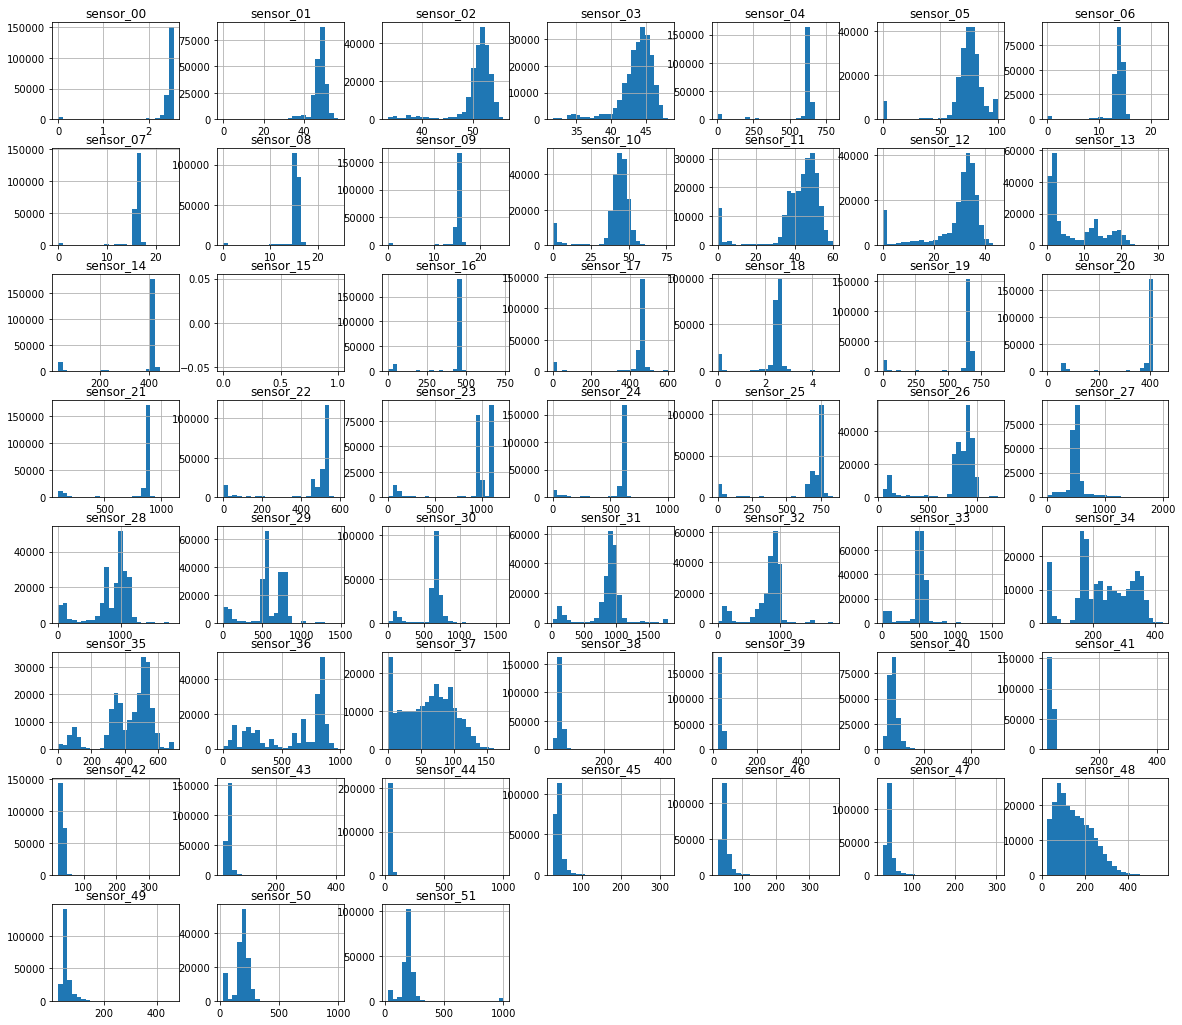

In [14]:
# Histogram
df.hist(df.columns, bins=25, layout=(8,7), figsize=(20, 18))
plt.show()

### 2.3 - Clean the data
* Remove redundant columns
* Remove duplicates
* Handle missing values
* Convert data types to the correct data type

Keep in mind: there are data formats that are better for reporting vs. better for analysis; tidy data makes it easier to fix common data problems

**Remove duplicates from the dataframe**

In [15]:
# Drop duplicates
df = df.drop_duplicates()

In [16]:
df.shape

(220320, 54)

**Handle Missing Values**

In [17]:
# Entire "sensor_15" column is NaN therefore removing the entire column from the data set
del df['sensor_15']

In [18]:
df.shape

(220320, 53)

In [19]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [20]:
# Let's take a look at top ten columns with missing values
calc_percent_NAs(df).head(10)

,percent
sensor_50,0.349569
sensor_51,0.069821
sensor_00,0.046333
sensor_07,0.024741
sensor_08,0.023180
sensor_06,0.021777
sensor_09,0.020856
sensor_01,0.001675
sensor_30,0.001185
sensor_29,0.000327


In [21]:
df[['sensor_50', 'sensor_51', 'sensor_00', 'sensor_07', 'sensor_08', 'sensor_06', 'sensor_09']].describe().T

,count,mean,std,min,25%,50%,75%,max
sensor_50,143303.0,183.049260,65.258650,27.488426,167.534700,193.865700,219.907400,1000.000000
sensor_51,204937.0,202.699667,109.588607,27.777779,179.108800,197.338000,216.724500,1000.000000
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_09,215725.0,14.799210,2.091963,0.000000,15.053530,15.082470,15.118630,25.000000


Let's fill NAs in columns sensor_50, sensor_51, sensor_00, sensor_07, sensor_08, sensor_06 and sensor_09 with their mean values as they are 1% of the entire data set. The rest of the columns with NaNs will be removed from the data set.

In [22]:
df['sensor_50'].fillna((df['sensor_50'].mean()), inplace=True)
df['sensor_51'].fillna((df['sensor_51'].mean()), inplace=True)
df['sensor_00'].fillna((df['sensor_00'].mean()), inplace=True)
df['sensor_08'].fillna((df['sensor_08'].mean()), inplace=True)
df['sensor_07'].fillna((df['sensor_07'].mean()), inplace=True)
df['sensor_06'].fillna((df['sensor_06'].mean()), inplace=True)
df['sensor_09'].fillna((df['sensor_09'].mean()), inplace=True)

In [23]:
#Use linear interpolation to fill up nulls
#df = df.interpolate(method='pad', limit_direction="forward", axis=0)
#df = df.interpolate(method='linear', axis=0).ffill().bfill()
#df3.head(10)

In [24]:
df_tidy = df.dropna()

In [25]:
# Check if any dates are missing
#daily_data = pd.DataFrame(pd.date_range(start=df['timestamp'].min(),end=df['timestamp'].max()))
#daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
#daily_data.describe()

In [26]:
# Add the missing dates
#df2 = pd.merge(df,daily_data,on='Date',how='outer')
#df2 = df2.sort_values(by=['Date'])
#df2.head(10)

In [27]:
# Let's convert the data type of timestamp column to datatime format
import warnings
warnings.filterwarnings("ignore")
df_tidy['date'] = pd.to_datetime(df_tidy['timestamp'])
del df_tidy['timestamp']

In [28]:
df_tidy = df_tidy.set_index('date')
df_tidy.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
date,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [29]:
df_tidy.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,...,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000,219521.000000
mean,2.371961,47.590015,50.863387,43.746718,590.629672,73.397642,13.500351,15.841237,15.198273,14.796988,...,35.445976,43.878502,42.650970,43.085801,48.012455,44.327382,150.901538,57.121069,183.016279,202.719224
std,0.403223,3.299447,3.668355,2.417856,144.127709,17.304487,2.143252,2.176726,2.015901,2.072470,...,10.275169,11.061115,11.592033,12.852025,15.657217,10.448843,82.332042,19.170952,52.671229,105.868122
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.417187,46.310760,50.390620,42.838539,626.620400,69.982320,13.346350,15.856480,15.183740,15.010130,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.622690,47.743060,182.581000,180.555600
50%,2.455556,48.133678,51.649300,44.227428,632.754600,75.578420,13.628470,16.167530,15.451390,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.245370,138.020800,52.662040,183.049260,199.942100
75%,2.499826,49.479160,52.777770,45.225693,637.615723,80.918750,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.622700,60.763890,204.571800,215.277800
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [30]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219521 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       219521 non-null  float64
 1   sensor_01       219521 non-null  float64
 2   sensor_02       219521 non-null  float64
 3   sensor_03       219521 non-null  float64
 4   sensor_04       219521 non-null  float64
 5   sensor_05       219521 non-null  float64
 6   sensor_06       219521 non-null  float64
 7   sensor_07       219521 non-null  float64
 8   sensor_08       219521 non-null  float64
 9   sensor_09       219521 non-null  float64
 10  sensor_10       219521 non-null  float64
 11  sensor_11       219521 non-null  float64
 12  sensor_12       219521 non-null  float64
 13  sensor_13       219521 non-null  float64
 14  sensor_14       219521 non-null  float64
 15  sensor_16       219521 non-null  float64
 16  sensor_17       219521

In [31]:
df_tidy.shape

(219521, 52)

In [32]:
df_tidy.isna().sum()

sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0
sensor_50         0


**Handling outliers**

The proper action towards handling outliers depends on what causes the outliers. In broad strokes, there are three causes for outliers—data entry or measurement errors, sampling problems and unusual conditions, and natural variation. Since the purpose of this study is focused on anomaly detection, we need to be really careful about how to handle outliers as opposed to just removing them from the dataset. The outliers may represent unusual conditions which may represent the anomalies we are looking for. With that, let's keep the outliers for now and look at them more closely in the next step.



In [33]:
# Write the dataframe to csv 
df_tidy.to_csv('step2-output-cleaned.csv')

In [34]:
# let's have a look at how many labels each variable has
print(len(df['machine_status'].unique()), ' labels')

3  labels


In [35]:
# let's have a look at how many labels each variable has
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [36]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["machine_status"] = lb_make.fit_transform(df["machine_status"])
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,1
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,1
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,1


In [37]:
list(lb_make.inverse_transform([0, 1, 2]))

['BROKEN', 'NORMAL', 'RECOVERING']

In [38]:
df2 = df.drop(['machine_status'], axis=1)
names=df2.columns
X = df[names]
y = df.drop(df2.columns, axis=1)

In [39]:
# Write the dataframe to csv 
X.to_csv('X.csv')
y.to_csv('y.csv')

In [40]:
X.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889
